<a href="https://colab.research.google.com/github/massinoLight/HandwrittenSignatureForgeryDetectionUsingCNN/blob/master/Handwritten_Signature_Forgery_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-addons

In [3]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pathlib
import os
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
#Import dataset
import pathlib
import os
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/massinoLight/HandwrittenSignatureForgeryDetectionUsingCNN/blob/master/datasets.zip?raw=true",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')



In [4]:
!rm -rf /content/datasets/__MACOSX/

In [5]:
import pathlib
import os
import tensorflow as tf
data_dir = pathlib.Path('/content/datasets/datasets')
print(data_dir)
print(os.path.abspath(data_dir))

totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(data_dir):
    
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

#image_count = len(list(data_dir.glob('*/')))
print(str(totalDir)+" Dossiers")
print(str(totalFiles)+" Fichiers")

/content/datasets/datasets
/content/datasets/datasets
2 Dossiers
49 Fichiers


In [6]:
batch_size = 1
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 48 files belonging to 2 classes.
Using 39 files for training.
Found 48 files belonging to 2 classes.
Using 9 files for validation.
['Sig1Fake', 'Sig1Orig']


In [7]:


#le on définie le nombre de classes ici nous disposons de 2 Forgery et Genuine Signatures
num_classes = 2


model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3),
                         activation=tfa.activations.gelu),
  tfa.layers.GroupNormalization(groups=5, axis=3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])


"""

#on va définir notre réseau de neuron (ici avec 4 couches )
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])"""




"\n\n#on va définir notre réseau de neuron (ici avec 4 couches )\nmodel = tf.keras.Sequential([\n    layers.experimental.preprocessing.Rescaling(1./255),\n    layers.Conv2D(128,4, activation='relu'),\n    layers.MaxPooling2D(),\n    layers.Conv2D(64,4, activation='relu'),\n    layers.MaxPooling2D(),\n    layers.Conv2D(32,4, activation='relu'),\n    layers.MaxPooling2D(),\n    layers.Conv2D(16,4, activation='relu'),\n    layers.MaxPooling2D(),\n    layers.Flatten(),\n    layers.Dense(64,activation='relu'),\n    layers.Dense(num_classes, activation='softmax')\n])"

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data, epochs=10, 
                    validation_data=train_data)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/activations/gelu.py:80: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


39/39 [==============================] - 4s 21ms/step - loss: 226.6973 - accuracy: 0.3765 - val_loss: 16.7214 - val_accuracy: 0.5641
Epoch 2/10
39/39 [==============================] - 0s 12ms/step - loss: 27.3284 - accuracy: 0.4991 - val_loss: 24.1908 - val_accuracy: 0.5641
Epoch 3/10
39/39 [==============================] - 0s 12ms/step - loss: 14.5622 - accuracy: 0.7334 - val_loss: 0.9196 - val_accuracy: 0.9744
Epoch 4/10
39/39 [==============================] - 0s 12ms/step - loss: 0.9105 - accuracy: 0.9810 - val_loss: 8.5024 - val_accuracy: 0.7949
Epoch 5/10
39/39 [==============================] - 0s 12ms/step - loss: 4.0733 - accuracy: 0.9028 - val_loss: 1.9027 - val_accuracy: 0.9487
Epoch 6/10
39/39 [==============================] - 0s 12ms/step - loss: 9.2564 - accuracy: 0.8076 - val_loss: 3.8416 - val_accuracy: 0.8718
Epoch 7/10
39/39 [==============================] - 0s 12ms/step - loss: 0.5527 - accuracy: 0.9131 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/10
39/

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 10)      280       
_________________________________________________________________
group_normalization (GroupNo (None, 198, 198, 10)      20        
_________________________________________________________________
flatten (Flatten)            (None, 392040)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                3920410   
Total params: 3,920,710
Trainable params: 3,920,710
Non-trainable params: 0
_________________________________________________________________


In [10]:
url_valide = r'http://7agestion.fr/wp-content/uploads/2017/03/ok-2282499_640.png'
resp = requests.get(url_valide, stream=True).raw
image_array_valide = np.asarray(bytearray(resp.read()), dtype="uint8")

image_valide = cv2.imdecode(image_array_valide, cv2.IMREAD_COLOR)


url_fake = r'https://png.pngtree.com/png-clipart/20190924/original/pngtree-false-free-png-png-image_4863857.jpg'
resp = requests.get(url_fake, stream=True).raw
image_array_fake = np.asarray(bytearray(resp.read()), dtype="uint8")

image_fake = cv2.imdecode(image_array_fake, cv2.IMREAD_COLOR)


Saving original_1_2.png to original_1_2.png


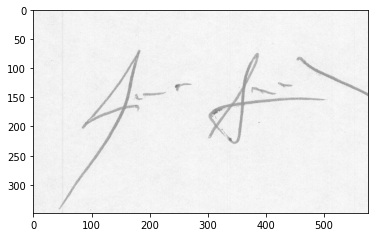

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1]
[[6.6069273e-15 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[1]


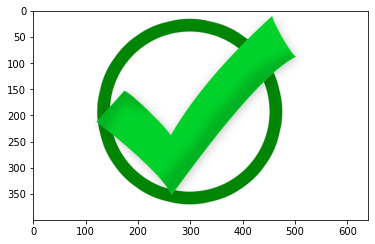

ce est une vrai !


In [13]:
from google.colab import files
file_to_predict = files.upload()
for file_ in file_to_predict:
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0) 
    res = model.predict_classes(img_to_predict)
    print(model.predict_classes(img_to_predict))
    print(model.predict(img_to_predict))
    print(res)
    if res == 1:
        plt.imshow(cv2.cvtColor(image_valide, cv2.COLOR_BGR2RGB))
        plt.show()
        print("ce est une vrai !")
    elif res == 0 :
        plt.imshow(cv2.cvtColor(image_fake, cv2.COLOR_BGR2RGB))
        plt.show()
        print("c'est une fausse  !")

Saving forgeries_1_12.png to forgeries_1_12.png


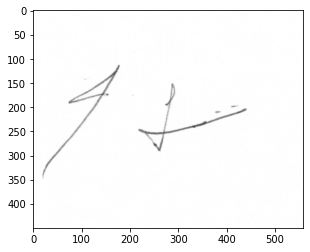

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1]
[[0.49508393 0.5049161 ]]
[1]


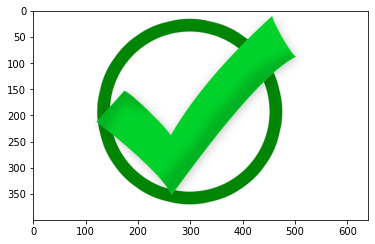

ce est une vrai !


In [ ]:
from google.colab import files
file_to_predict = files.upload()
for file_ in file_to_predict:
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(400,400)), axis=0) 
    res = model.predict_classes(img_to_predict)
    print(model.predict_classes(img_to_predict))
    print(model.predict(img_to_predict))
    print(res)
    if res == 1:
        plt.imshow(cv2.cvtColor(image_valide, cv2.COLOR_BGR2RGB))
        plt.show()
        print("ce est une vrai !")
    elif res == 0 :
        plt.imshow(cv2.cvtColor(image_fake, cv2.COLOR_BGR2RGB))
        plt.show()
        print("c'est une fausse  !")